# Import some libraries

In [91]:
import cv2
import matplotlib.pyplot as plt
import yaml
import numpy as np
import math
import PID

# Capture one frame

In [92]:
cap = cv2.VideoCapture(0)
ret,img = cap.read()

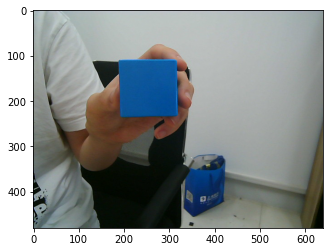

In [93]:
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)  
plt.imshow(img)

# Image Processing (refer to [Color_Identification.ipynb](https://github.com/guyuxuan9/UROP_robotic_arm/blob/main/Camera/Color_Identification.ipynb) for details)

In [94]:
img_copy = img.copy()
img_h, img_w = img.shape[:2]
print(img_h,img_w)

480 640


In [95]:
size = (640, 480)
frame_resize = cv2.resize(img_copy, size, interpolation=cv2.INTER_NEAREST)
frame_gb = cv2.GaussianBlur(frame_resize, (3, 3), 3)
frame_lab = cv2.cvtColor(frame_gb, cv2.COLOR_BGR2LAB)

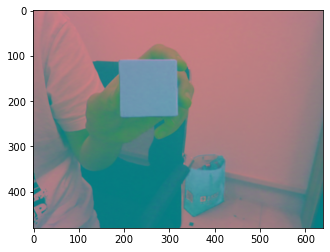

In [96]:
# frame in lab space
plt.imshow(frame_lab)

## Get the range of LAB values for this blue colour
Extract part of the blue object and zoom in:

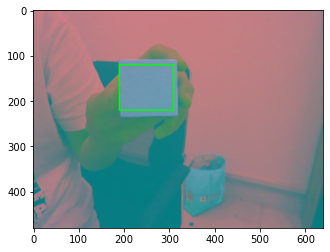

In [109]:

frame_lab_rect = frame_lab.copy()
cv2.rectangle(frame_lab_rect, (190, 120), (310, 220), (0, 255, 0), 2)
plt.imshow(frame_lab_rect)

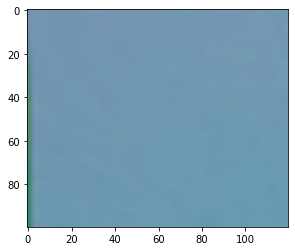

In [108]:
new_image = frame_lab[120:220,190:310]
plt.imshow(new_image)

- Get the LAB range for this blue colour and update the yaml file
- Make sure the range is reasonable enough so that:
    1. It is large enough to include all the area of the blue object
    2. It is small enough to exlcude other colour in other areas

In [110]:
def get_lab_range(image):
    # Split the LAB image into its channels
    L, A, B = cv2.split(image)

    # Find the minimum and maximum values for each channel
    L_min, L_max = np.min(L), np.max(L)
    A_min, A_max = np.min(A), np.max(A)
    B_min, B_max = np.min(B), np.max(B)

    return (L_min, L_max), (A_min, A_max), (B_min, B_max)
lab_range = get_lab_range(new_image)
print("LAB Values Range:")
print("L:", lab_range[0])
print("A:", lab_range[1])
print("B:", lab_range[2])

LAB Values Range:
L: (55, 121)
A: (132, 158)
B: (101, 181)


## Get the LAB values in the lab_config.yaml file

In [100]:
def get_yaml_data(yaml_file):
    file = open(yaml_file, 'r', encoding='utf-8')
    file_data = file.read()
    file.close()
    
    data = yaml.load(file_data,Loader=yaml.SafeLoader)
    
    return data

In [101]:
lab_file_path = "lab_config.yaml"
lab_data = get_yaml_data(lab_file_path)
lab_data

{'blue': {'max': [170, 160, 200], 'min': [60, 125, 150]}}

## Image processing to eliminate the noise

In [102]:
__target_color = ('blue')
for i in lab_data:
    if i in __target_color:
        detect_color = i
        print(detect_color)
        print(lab_data[detect_color])
        frame_mask = cv2.inRange(frame_lab,
                                (lab_data[detect_color]['min'][0],
                                 lab_data[detect_color]['min'][1],
                                 lab_data[detect_color]['min'][2]),
                                             
                                 (lab_data[detect_color]['max'][0],
                                  lab_data[detect_color]['max'][1],
                                  lab_data[detect_color]['max'][2]))  
        opened = cv2.morphologyEx(frame_mask, cv2.MORPH_OPEN, np.ones((3, 3), np.uint8)) 
        closed = cv2.morphologyEx(opened, cv2.MORPH_CLOSE, np.ones((3, 3), np.uint8)) 
        contours = cv2.findContours(closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)[-2]  

blue
{'max': [170, 160, 200], 'min': [60, 125, 150]}


In [103]:
len(contours) # there are 7 contours but only the biggest one represents the blue object

7

In [104]:
contour_area_temp = 0
contour_area_max = 0
for c in contours:  
    print(c)
    contour_area_temp = math.fabs(cv2.contourArea(c))
    #print(contour_area_temp)
    if contour_area_temp > contour_area_max:
        contour_area_max = contour_area_temp
        if contour_area_temp > 300:
            areaMaxContour = c
print(areaMaxContour)
print(contour_area_max)

[[[350 425]]

 [[350 426]]

 [[349 427]]

 [[349 428]]

 [[349 429]]

 [[349 430]]

 [[349 431]]

 [[349 432]]

 [[350 432]]

 [[351 432]]

 [[352 432]]

 [[352 431]]

 [[352 430]]

 [[353 429]]

 [[353 428]]

 [[353 427]]

 [[353 426]]

 [[353 425]]

 [[352 425]]

 [[351 425]]]
[[[385 420]]

 [[385 421]]

 [[385 422]]

 [[386 422]]

 [[387 422]]

 [[388 422]]

 [[388 421]]

 [[388 420]]

 [[387 420]]

 [[386 420]]]
[[[339 417]]

 [[339 418]]

 [[339 419]]

 [[339 420]]

 [[340 420]]

 [[341 420]]

 [[342 420]]

 [[342 419]]

 [[342 418]]

 [[341 417]]

 [[340 417]]]
[[[420 337]]

 [[420 338]]

 [[419 339]]

 [[419 340]]

 [[418 341]]

 [[417 342]]

 [[416 343]]

 [[416 344]]

 [[416 345]]

 [[415 346]]

 [[414 346]]

 [[413 347]]

 [[412 347]]

 [[411 348]]

 [[410 348]]

 [[409 349]]

 [[408 349]]

 [[407 349]]

 [[406 350]]

 [[405 351]]

 [[404 351]]

 [[403 351]]

 [[402 352]]

 [[401 352]]

 [[400 352]]

 [[399 352]]

 [[398 352]]

 [[397 352]]

 [[396 352]]

 [[395 352]]

 [[394

In [105]:
def rescale(x, in_min, in_max, out_min, out_max):
    return (x - in_min) * (out_max - out_min) / (in_max - in_min) + out_min

## Draw the minimum enclosing circle and bounding box

In [106]:
if contour_area_max > 1000: # have the max area
    (center_x, center_y), radius = cv2.minEnclosingCircle(areaMaxContour)
    print("centre_x before: ",center_x)
    center_x = int(rescale(center_x, 0, size[0], 0, img_w))
    print("centre_x after: ",center_x)
    
    center_y = int(rescale(center_y, 0, size[1], 0, img_h))
    radius = int(rescale(radius, 0, size[0], 0, img_w))
    print("centre_y: ",center_y)
    print("radius: ",radius)

centre_x before:  254.5
centre_x after:  254
centre_y:  170
radius:  87


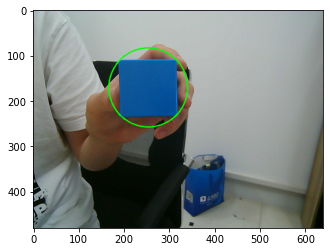

In [107]:
cv2.circle(img,(center_x,center_y),radius,(0,255,0),2)
plt.imshow(img)

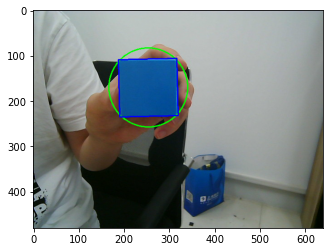

In [111]:
range_rgb = {
    'red': (255, 0, 0),
    'blue': (0, 0, 255),
    'green': (0, 255, 0),
    'black': (0, 0, 0),
    'white': (255, 255, 255),
}
rect = cv2.minAreaRect(areaMaxContour)
box = np.int0(cv2.boxPoints(rect))
cv2.drawContours(img, [box], -1, range_rgb[__target_color], 2)
plt.imshow(img)

# PID controller

In this scenario, the three PID controllers are used to track the object. They are used to control $x$, $y$, and $z$ position of the robotic arm respectively. 
- The feedback value is the center coordinates (center_x,center_y) of the object in the frame captured.
- The goal is the make the object appear in the centre of the image. Therefore, the setpoint of $x_{pid}$ is the center of honrizontal axis, i.e. $\frac{img_w}{2}$. It becomes more complicated to determine the setpoint of $y_{pid}$ because it represents the distance from the camera to the object. A depth camera is needed to measure the distance as a feedback. However, there are clever ways to achieve the same goal. The object becomes larger when it is closer to the camera and vice versa. Hence, the total area of the object in the frame can be used to indicate the distance between the object and the camera. After trial and error, $9000$ (approx. $95 \times 95$ pixels) is used to be the setpoint of $y_{pid}$. Finally, from the common sense, the setpoint of $z_{pid}$ is $\frac {img_h}{2}$ 
- The output of the PID controller is the next coordinates the robotic arm should move to, and this is the input of the actuator. Then, using inverse kinematics, the angle each servo motor should move is calculated, after which the pulse width of each motor is calculated based on the angle input and we are done!
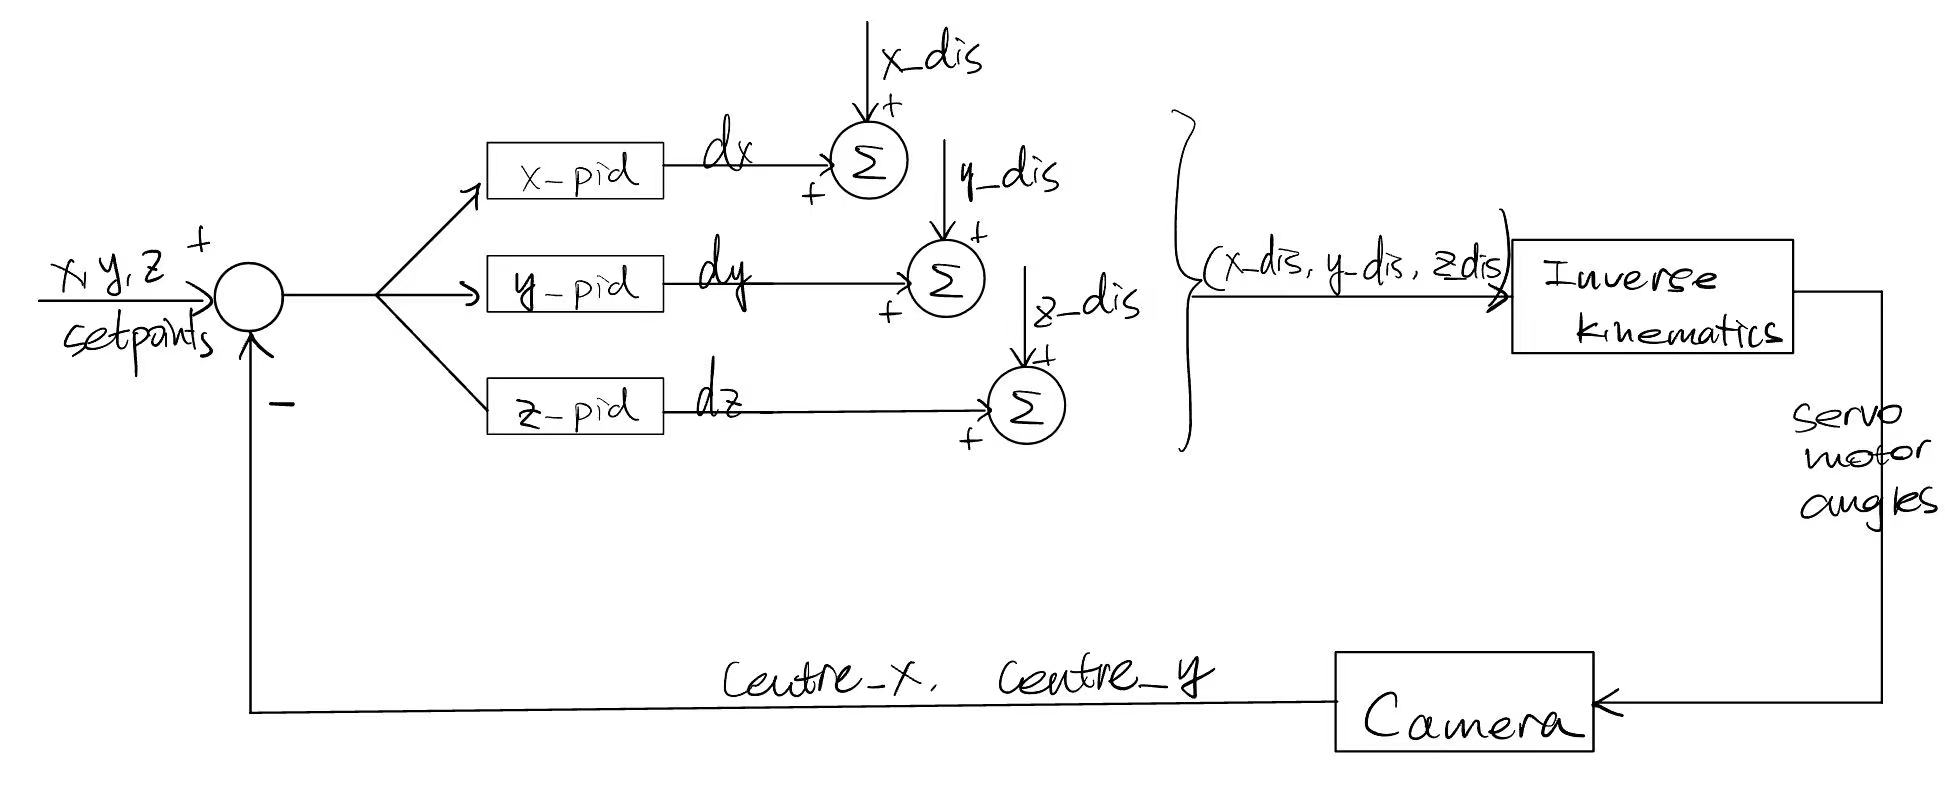

In [112]:
x_pid = PID.PID(P=0.1, I=0.00, D=0.008)  
y_pid = PID.PID(P=0.00001, I=0, D=0)
z_pid = PID.PID(P=0.005, I=0, D=0)

In [119]:
x_dis = 500
y_dis = 10
z_dis = 18


x_pid.SetPoint = img_w / 2.0
x_pid.update(center_x)  
dx = x_pid.output
x_dis += int(dx)  
x_dis = 0 if x_dis < 0 else x_dis
x_dis = 1000 if x_dis > 1000 else x_dis

y_pid.SetPoint = 9000  # expected area from the captured image
if abs(contour_area_max - 9000) < 50:
    contour_area_max = 9000
y_pid.update(contour_area_max)  
dy = y_pid.output
y_dis += dy  
y_dis = 5.00 if y_dis < 5.00 else y_dis
y_dis = 10.00 if y_dis > 10.00 else y_dis
    
if abs(center_y - img_h/2.0) < 20:
    z_pid.SetPoint = center_y
else:
    z_pid.SetPoint = img_h / 2.0
                
z_pid.update(center_y)
dy = z_pid.output
z_dis += dy
z_dis = 32.00 if z_dis > 32.00 else z_dis
z_dis = 10.00 if z_dis < 10.00 else z_dis

## Analyse PID outputs
This is an example of showing the output of the PID controllers.
- For $x_{pid}$, the current position of the object is 254 and the expected position is 320. Therefore, the robotic arm is expected to move to the right and $x_{dis}$ indicates this since the output value (506) is larger than the initial value (500).
- For $y_{pid}$, the current area (15814.5) is much larger than the expected one (9000). This means the object is closer to the camera than expected. Hence, the output $y_{dis} = 9.93$ moves the robot further from the object
- For $z_{pid}$, the current height is $center_y = 170$ and the expected height is $\frac{img_h}{2} = 240$ which is larger than the current value. Therefore, the output $z_{dis} = 18.35$ is greater than the old value (18), moving the camera upwards.

In [120]:
print("center_x: ",center_x, ", img_w/2: ",img_w/2)
print("center_y: ",center_y, ", img_h/2: ",img_h/2)
print("area: ",contour_area_max)

center_x:  254 , img_w/2:  320.0
center_y:  170 , img_h/2:  240.0
area:  15814.5


In [121]:
print("x_dis: ",x_dis)
print("y_dis: ",y_dis)
print("z_dis: ",z_dis)

x_dis:  506
y_dis:  9.931855
z_dis:  18.35
